In [4]:
!pip install pingouin
import pandas as pd
import seaborn as sns
import pingouin as pg
import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression as Log
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor as RFR
from scipy.stats import probplot
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix as cm
from sklearn.decomposition import FactorAnalysis as FA


# Tolerance function
def print_lintol(df):
  for col in df.columns:
    x = df.drop(col,axis=1)
    y = df[col]
    clf = LR()
    clf.fit(x,y)
    print(col)
    print(1 - clf.score(x,y))

#Stepwise Regression

def step_reg(df,target_col,significance_threshold,adj_r2_threshold):
  remaining_col = df.columns.to_list()
  remaining_col.remove(target_col)
  included_cols = []
  col_to_include = df.corr().drop(target_col).sort_values(target_col,ascending=False).index[0]
  print(col_to_include)
  included_cols.append(col_to_include)
  remaining_col.remove(col_to_include)
  clf = LR()
  X = df[included_cols].to_numpy()#[...,np.newaxis]
  y = df[target_col].to_numpy()
  #*******optional***
  scaler = StandardScaler()
  scaler.fit_transform(X)
  # #********
  clf.fit(X,y)
  max_adj_r2 = 1-(1-clf.score(X,y))*(X.shape[0]-1)/(X.shape[0]-X.shape[1]-1)
  print(max_adj_r2)
  while(len(included_cols) < (len(df.columns)-1)):
    max_r = 0
    col_to_include = None
    for col in remaining_col:
      df_temp = df[included_cols + [col,target_col]]
      pc = pg.partial_corr(df_temp,col,target_col,covar=included_cols)
      if (abs(pc['r'].iloc[0]) > max_r) and (pc['p-val'].iloc[0] < significance_threshold):
        col_to_include = col
        max_r = abs(pc['r'].iloc[0])
    if col_to_include == None:
      break
    included_cols.append(col_to_include)
    remaining_col.remove(col_to_include)
    clf = LR()
    #*******optional***
    scaler = StandardScaler()
    scaler.fit_transform(X)
    #********
    X = df[included_cols].to_numpy()
    y = df[target_col].to_numpy()
    clf.fit(X,y)
    Adj_r2 = 1-(1-clf.score(X,y))*(X.shape[0]-1)/(X.shape[0]-X.shape[1]-1)
    if (Adj_r2 - max_adj_r2) < adj_r2_threshold :
      print('adjusted r2 voilated')
      included_cols.remove(col_to_include)
      remaining_col.append(col_to_include)
      break
    else:
      print(col_to_include) 
      print(Adj_r2) 
      max_adj_r2 = Adj_r2
      min_tol = 1
      min_tol_col = None
      for col in included_cols:
        x = df[included_cols].drop(col,axis=1)
        y = df[col]
        clf = LR()
        #*******optional***
        scaler = StandardScaler()
        scaler.fit_transform(X)
        #********
        clf.fit(x,y)
        tol = 1 - clf.score(x,y)
        if tol < min_tol:
          min_tol = tol 
          min_tol_col = col
      print('min tolerance - ' + min_tol_col + ' - ' + str(min_tol))
  return(included_cols)



# Neural net
class basic_net(tf.keras.Model):
  def __init__(self,h1,h2,drop):
    super(basic_net, self).__init__()
    self.dense1 = tf.keras.layers.Dense(h1,'relu')
    self.dense2 = tf.keras.layers.Dense(h2,'relu')
    self.dense3 = tf.keras.layers.Dense(1)
    self.drop = tf.keras.layers.Dropout(drop)
  def call(self,x):
    x = self.dense1(x)
    x = self.dense2(x)
    x = self.dense3(self.drop(x))
    return(x)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)  


loss = tf.keras.losses.MeanSquaredError()

In [5]:
# Load data
dfo = pd.read_csv('kc_house_data.csv',encoding='latin').sample(frac=1)
dfo = dfo.drop(['id','date'],axis=1)
dfo['age'] = dfo['yr_built'].max() - dfo['yr_built'] # Adding a new feature, which I think could be better than year built
ttr = 0.25
df_test = dfo.iloc[:int(ttr*len(dfo))]
df_train = dfo.iloc[int(ttr*len(dfo)):]
df_train_pristine = df_train.copy()
df_test_pristine = df_test.copy()

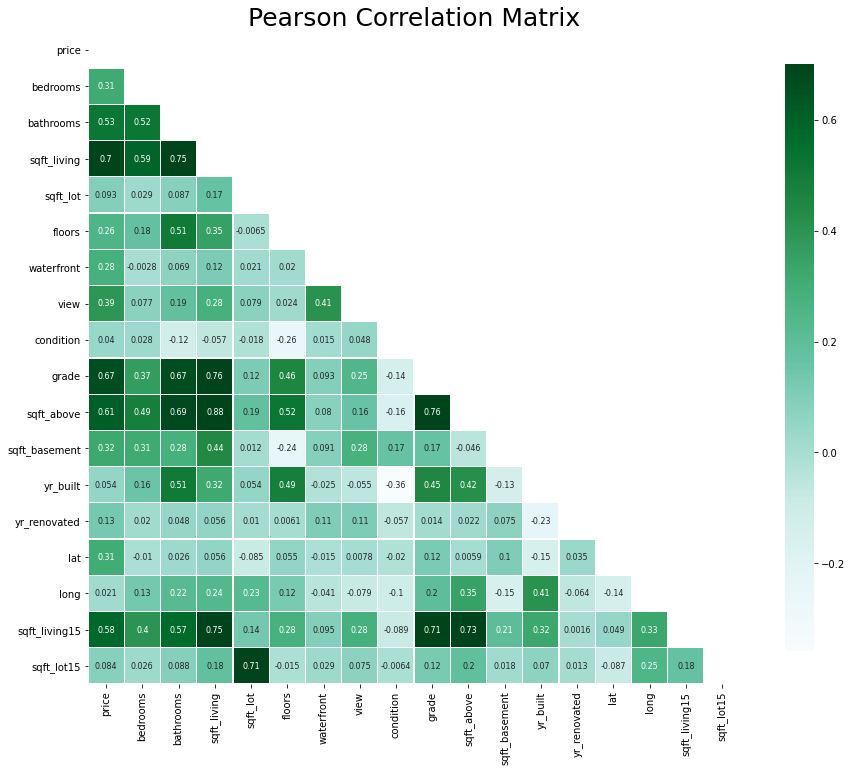

In [6]:
# Visualization Borrowed from - https://www.kaggle.com/burhanykiyakoglu/predicting-house-prices - Thanks !
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot15']

mask = np.zeros_like(df_train[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df_train[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

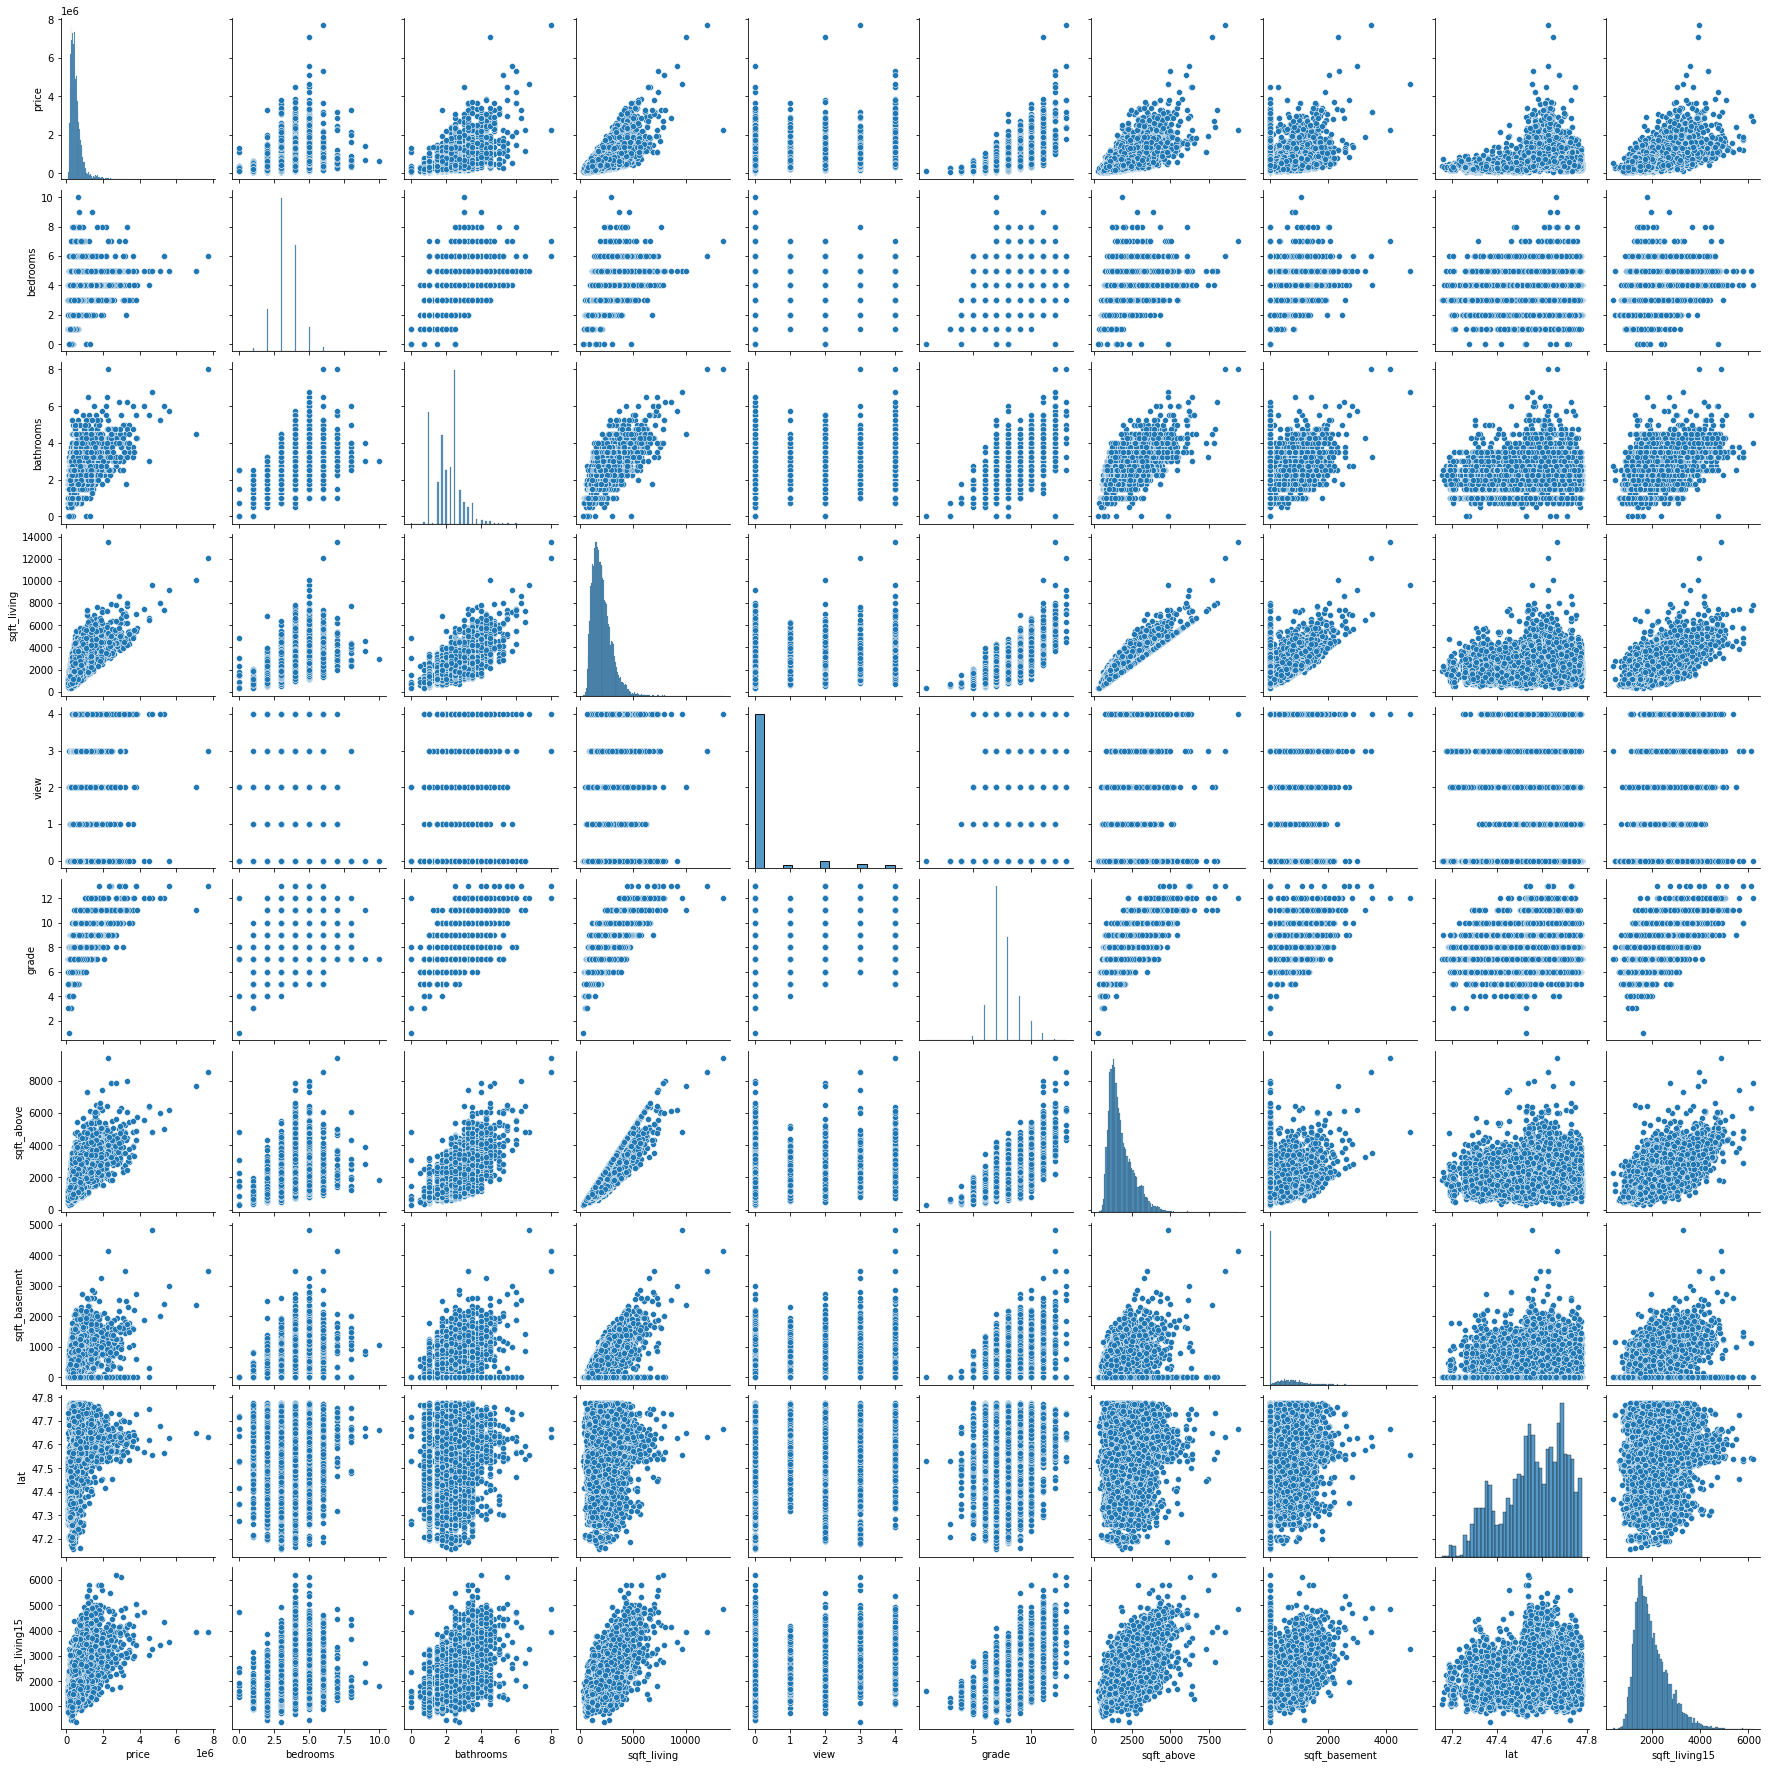

In [7]:
# Lets get the features having significant(I will take it as > 0.3) correlation with price. We may include the other features as well, but there is little hope they would be any useful.
significant_features = ['price','bedrooms','bathrooms','sqft_living',
            'view','grade','sqft_above','sqft_basement','lat','sqft_living15']
sns.pairplot(df_train_pristine[significant_features])

In [8]:
#baseline Regression
scaler = StandardScaler()
X = df_train_pristine.drop('price',axis=1).to_numpy()
y = df_train_pristine['price'].to_numpy()
X = scaler.fit_transform(X)
x_test = df_test_pristine.drop('price',axis=1).to_numpy()
x_test = scaler.transform(x_test)
y_test = df_test_pristine['price'].to_numpy()

clf_baseline = LR()
clf_baseline.fit(X,y)

R2 = clf_baseline.score(x_test,y_test)
print('R2 - ' + str(R2))
print('adj R2 - ' + str(1-(1-R2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))
print(df_test_pristine.drop('price',axis=1).columns.to_list())
print(clf_baseline.coef_)

R2 - 0.6895517665259111
adj R2 - 0.6884559990289749
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age']
[-36560.73990298  33286.36677982  84542.10276831   6493.78200347
   3097.8076273   54713.70533873  38058.31094472  18560.62417324
 112579.44703053  79877.98545816  26424.53755044 -39024.84559016
   8911.48901961 -32827.70798826  83166.54081955 -32275.89607594
  13104.19669465 -11340.57415963  39024.84559016]


In [9]:
#Feature transformations on complete data
# df_pristine = dfo.copy()
df = dfo
df['sqft_above'] = np.log(df['sqft_above'].to_numpy())
df['price'] = np.log(df['price'].to_numpy())
df['sqft_living'] = np.log(df['sqft_living'].to_numpy())
df['sqft_living15'] = np.log(df['sqft_living15'].to_numpy())
df['sqft_basement'] = np.log(df['sqft_basement'].to_numpy() + 1) # added 1, as log of zero is not defined.

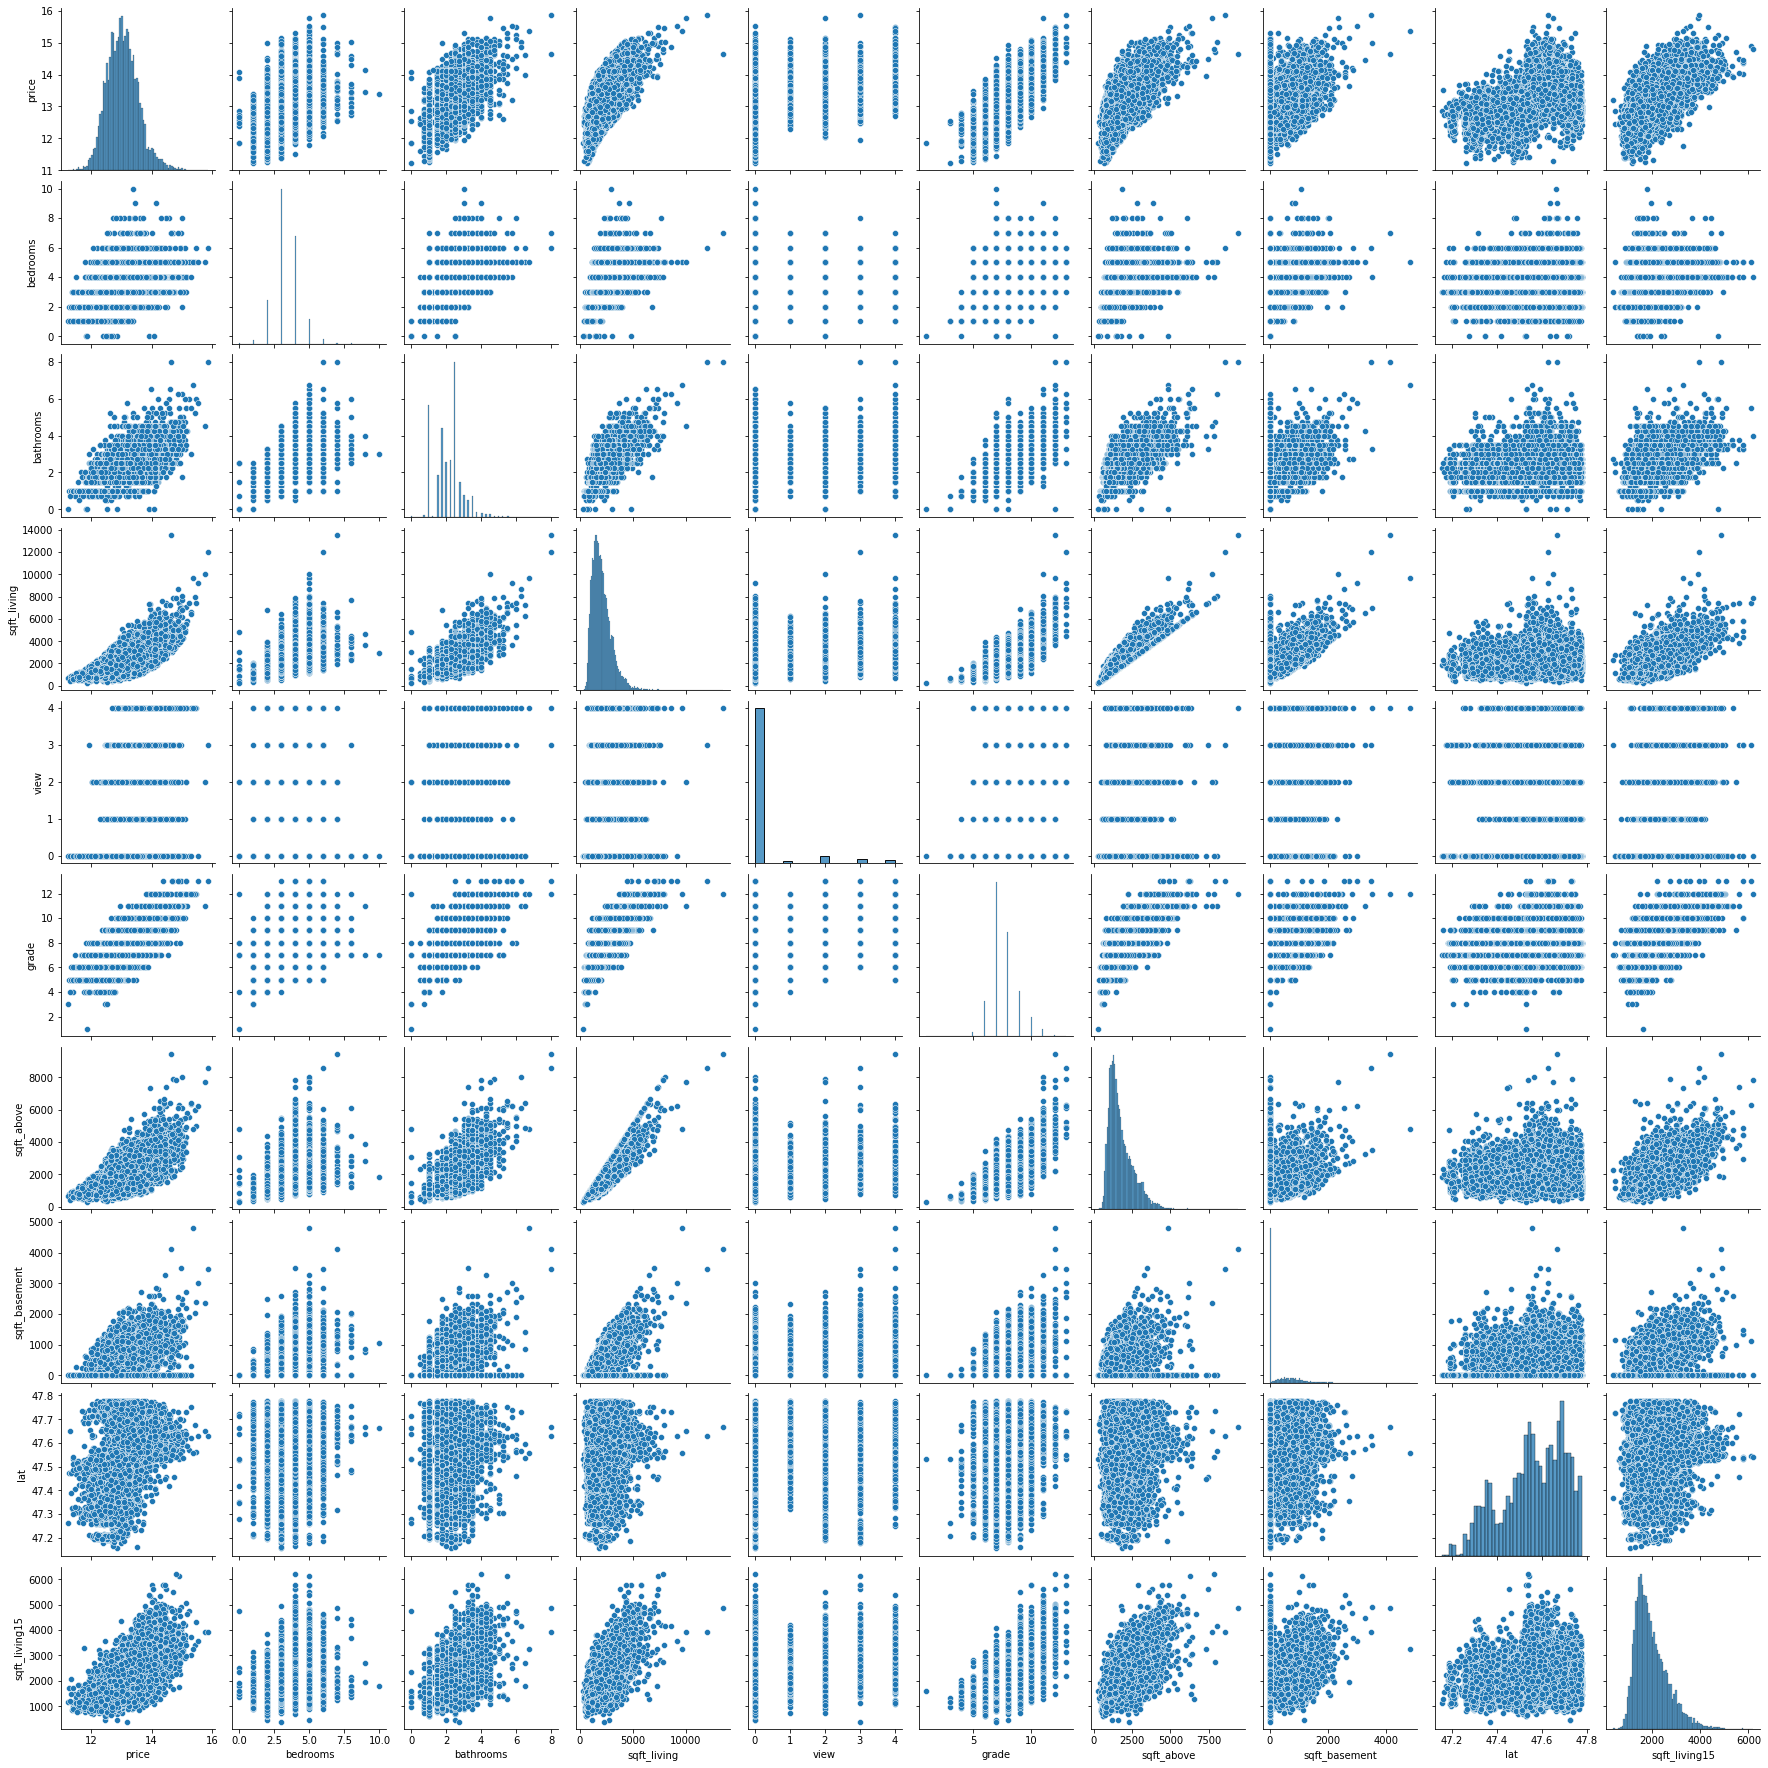

In [10]:
sns.pairplot(df_train[significant_features])

In [11]:
#Tolerance values
print('Tolerances for different variables')
print_lintol(df_train.drop('price',axis=1))

Tolerances for different variables
bedrooms
0.5858863976024321
bathrooms
0.29694421863717146
sqft_living
0.0
sqft_lot
0.48179894494531417
floors
0.49561612998945515
waterfront
0.8235538401905197
view
0.6936064089415186
condition
0.8023780000552362
grade
0.2912915631714542
sqft_above
0.0
sqft_basement
0.0
yr_built
0.0
yr_renovated
0.8672893661854408
zipcode
0.6005860122488036
lat
0.8481069889002959
long
0.5473425343904617
sqft_living15
0.33930386383916267
sqft_lot15
0.475171899784409
age
0.0


In [12]:
#stepwise_regression
target_col = 'price'
significance_threshold = 0.01
adj_r2_threshold = 0.003

selected_cols = step_reg(df_train,target_col,significance_threshold,adj_r2_threshold)

grade
0.49848641182078746
lat
0.6353395280267914
min tolerance - grade - 0.9863018604982446
sqft_living
0.7039796532355501
min tolerance - grade - 0.41245561102887973
yr_built
0.7320630416556038
min tolerance - grade - 0.35777086231817745
view
0.7449403121011855
min tolerance - grade - 0.3521833454444223
bathrooms
0.7500823314053867
min tolerance - sqft_living - 0.2878208753944477
sqft_living15
0.7548982774484962
min tolerance - sqft_living - 0.2335569954018326
condition
0.7591533588501468
min tolerance - sqft_living - 0.23336414079487888
waterfront
0.7627863823087206
min tolerance - sqft_living - 0.23319618288571098
adjusted r2 voilated


In [13]:
# Regression on transformed data
scaler = StandardScaler()
X = df_train[selected_cols].to_numpy()
y = df_train['price'].to_numpy()
X = scaler.fit_transform(X)
x_test = df_test[selected_cols].to_numpy()
x_test = scaler.transform(x_test)
y_test = df_test['price'].to_numpy()

clf_lr = LR()
clf_lr.fit(X,y)

R2 = clf_lr.score(x_test,y_test)
print('R2 - ' + str(R2))
print('adj R2 - ' + str(1-(1-R2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))
print(df_test[selected_cols].columns.to_list())
print(clf_lr.coef_)

R2 - 0.7634942039008883
adj R2 - 0.7630995159415166
['grade', 'lat', 'sqft_living', 'yr_built', 'view', 'bathrooms', 'sqft_living15', 'condition', 'waterfront']
[ 0.20441446  0.18937868  0.11861007 -0.09535866  0.04403263  0.0683029
  0.06193839  0.03753717  0.03499141]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


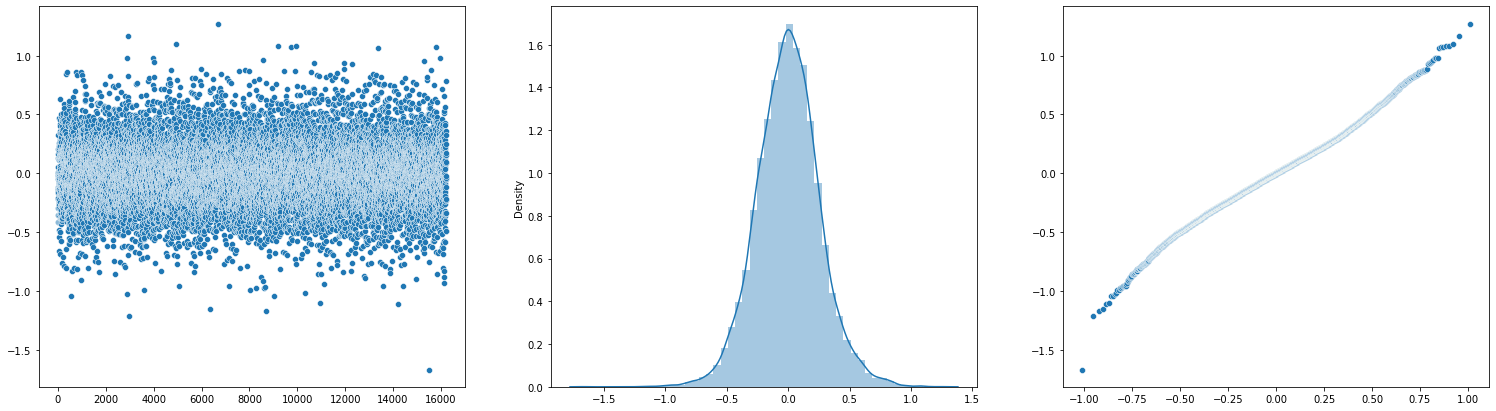

In [14]:
#Training residuals
res = (y - clf_lr.predict(X))
fig, axs = plt.subplots(ncols=3,figsize=(26,7))
qq,_ = probplot(res,sparams=(0,np.std(res)))
sns.scatterplot(np.arange(X.shape[0]),res,ax=axs[0])
sns.distplot(res,ax=axs[1])
sns.scatterplot(qq[0],qq[1],ax=axs[2])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


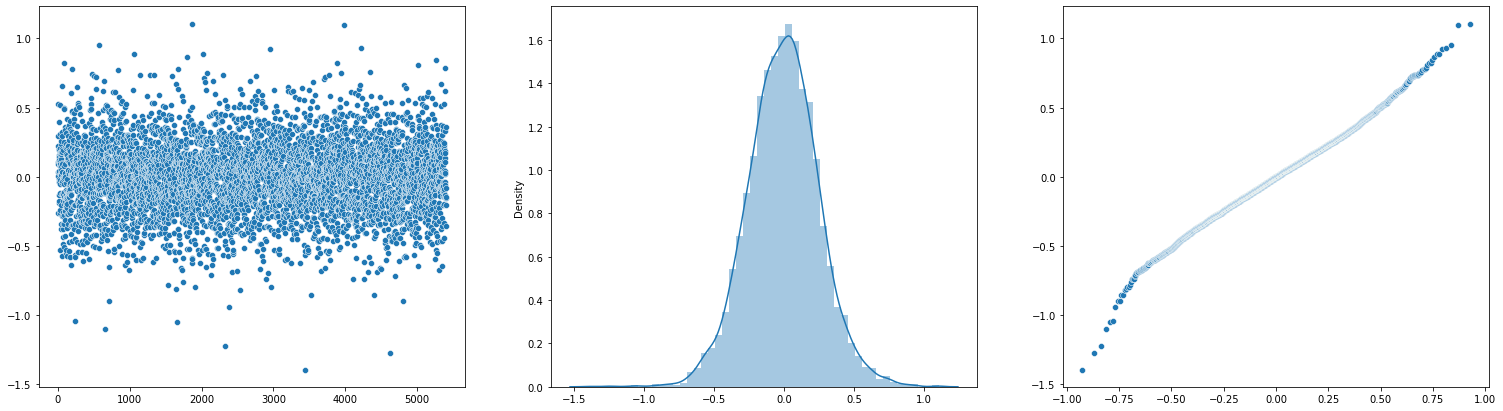

In [15]:
#Test residuals
res = (y_test - clf_lr.predict(x_test))
fig, axs = plt.subplots(ncols=3,figsize=(26,7))
qq,_ = probplot(res,sparams=(0,np.std(res)))
sns.scatterplot(np.arange(x_test.shape[0]),res,ax=axs[0])
sns.distplot(res,ax=axs[1])
sns.scatterplot(qq[0],qq[1],ax=axs[2])

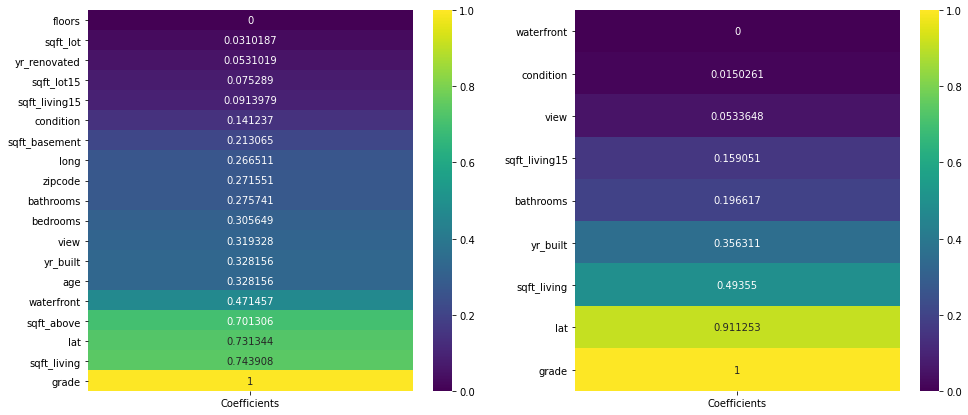

In [16]:
#Coefficient visualization
coeff = np.abs(clf_baseline.coef_)
coef_baseline = (coeff- (np.min(coeff)))/ (np.max(coeff) - np.min(coeff))
index = np.argsort(coef_baseline)
coef_baseline = coef_baseline[index]
base_cols = df_test.drop('price',axis=1).columns
cols = []
for i in index:
  cols.append(base_cols[i])
df_baseline = pd.DataFrame({"Coefficients": coef_baseline },
                  index=cols)



coeff = np.abs(clf_lr.coef_)
coef_final = (coeff- (np.min(coeff)))/ (np.max(coeff) - np.min(coeff))
index = np.argsort(coef_final)
coef_final = coef_final[index]
final_cols = df_test[selected_cols].columns
cols = []
for i in index:
  cols.append(final_cols[i])
df_final = pd.DataFrame({"Coefficients": coef_final},
                  index=cols)


fig, axs = plt.subplots(ncols=2,figsize=(16,7))
sns.heatmap(df_baseline, annot=True, fmt="g", cmap='viridis',ax=axs[0])
sns.heatmap(df_final, annot=True, fmt="g", cmap='viridis',ax=axs[1])
plt.show()

In [17]:
#Correlation differences after transformations
corr_at = df_train.corr().drop('price')['price']
corr_bt = df_train_pristine.corr().drop('price')['price']
((corr_at - corr_bt)/corr_bt)*100*(corr_at>0.3).astype(int)

bedrooms         11.662133
bathrooms         5.160829
sqft_living      -1.093930
sqft_lot          0.000000
floors           21.942107
waterfront       -0.000000
view            -12.859318
condition         0.000000
grade             5.795805
sqft_above       -0.560555
sqft_basement    -2.979121
yr_built          0.000000
yr_renovated     -0.000000
zipcode          -0.000000
lat              47.373251
long              0.000000
sqft_living15     6.107175
sqft_lot15        0.000000
age               0.000000
Name: price, dtype: float64

In [18]:
#Polynomial Features regression
scaler = StandardScaler()
poly = PolynomialFeatures(3)
X = df_train[selected_cols].to_numpy()
y = df_train['price'].to_numpy()
X = poly.fit_transform(scaler.fit_transform(X))
x_test = df_test[selected_cols].to_numpy()
x_test = poly.fit_transform(scaler.transform(x_test))
y_test = df_test['price'].to_numpy()

clf_pr = LR()
clf_pr.fit(X,y)

r2 = clf_pr.score(x_test,y_test)
adj_r2 = 1-(1-r2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)
print('R2 - ' + str(r2))
print('adj R2 - ' + str(adj_r2))

R2 - 0.8408275255131366
adj R2 - 0.8340699137055121


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wit

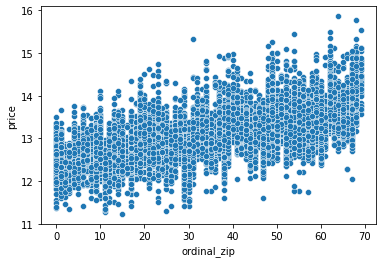

In [19]:
# Build ordinal zip code
def get_ordinal_zip(x):
  return(zip.loc[x]['ordinal_zip'])

# df_train['zip_index'] = df_train['zipcode'].apply(get_ordinal_zip)
df_train['ppsf'] = df_train_pristine['price']/df_train_pristine['sqft_living'] #New variable, price per square foot
zip = df_train.groupby('zipcode').mean()
zip.sort_values('ppsf',inplace=True)
zip['ordinal_zip'] = np.arange(len(zip))

df_train['ordinal_zip'] = df_train['zipcode'].apply(get_ordinal_zip) # New feature
sns.scatterplot(df_train['ordinal_zip'],df_train['price'])

R2 for predicting ordinal zip from lat and long - 0.9994769682461805


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


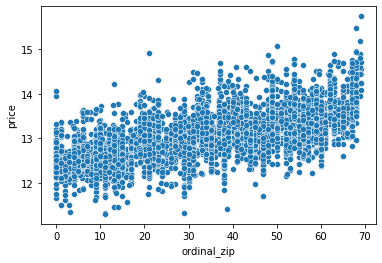

In [20]:
#Learn to predict ordinal zipcode directly from latitude and longitude
X = df_train[['lat','long']].to_numpy()
y = df_train['ordinal_zip'].to_numpy()


clf_zip = RFR()
clf_zip.fit(X,y)
print('R2 for predicting ordinal zip from lat and long - ' + str(clf_zip.score(X,y)))

def reg_zip_index(abc):
  x = abc.to_numpy()[np.newaxis,...]
  return(clf_zip.predict(x)[0])

df_test['ordinal_zip'] = df_test[['lat','long']].apply(reg_zip_index,axis=1)
sns.scatterplot(df_test['ordinal_zip'],df_test['price'])

In [21]:
# regression with ordinal zipcode
selected_cols1 = selected_cols + ['ordinal_zip'] # add new variable to already selected columns
scaler = StandardScaler()
X = df_train[selected_cols1].to_numpy()
y = df_train['price'].to_numpy()
X = scaler.fit_transform(X)
x_test = df_test[selected_cols1].to_numpy()
x_test = scaler.transform(x_test)
y_test = df_test['price'].to_numpy()

clf_lr = LR()
clf_lr.fit(X,y)

R2 = clf_lr.score(x_test,y_test)
print('R2 - ' + str(R2))
print('adj R2 - ' + str(1-(1-R2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)))
print(df_test.drop('price',axis=1).columns.to_list())
print(clf_baseline.coef_)

R2 - 0.8593330512791634
adj R2 - 0.8590721704395476
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age', 'ordinal_zip']
[-36560.73990298  33286.36677982  84542.10276831   6493.78200347
   3097.8076273   54713.70533873  38058.31094472  18560.62417324
 112579.44703053  79877.98545816  26424.53755044 -39024.84559016
   8911.48901961 -32827.70798826  83166.54081955 -32275.89607594
  13104.19669465 -11340.57415963  39024.84559016]


In [22]:
selected_cols1 = step_reg(df_train.drop('ppsf',axis=1),target_col,significance_threshold,adj_r2_threshold)

grade
0.49848641182078746
ordinal_zip
0.7495691640155078
min tolerance - ordinal_zip - 0.9654768137293807
sqft_living
0.8346142373521257
min tolerance - grade - 0.40253673449129135
waterfront
0.8439652963353648
min tolerance - grade - 0.4025246338243105
sqft_living15
0.8529996645445013
min tolerance - sqft_living - 0.3253682056294668
condition
0.8574966374469967
min tolerance - sqft_living - 0.32304840783535105
adjusted r2 voilated


In [23]:
# Simple Neural Net
selected_cols1 = selected_cols
if 'long' not in selected_cols1:
  selected_cols1 = selected_cols + ['long']
scalerx = StandardScaler()
scalery = StandardScaler()
# X = df_train.drop('price',axis=1).to_numpy()
X = df_train_pristine[selected_cols1].to_numpy()
y = df_train_pristine['price'].to_numpy()
X = scalerx.fit_transform(X)
y = scalery.fit_transform(y[...,np.newaxis])[:,0]
# x_test = df_test.drop('price',axis=1).to_numpy()
x_test = df_test_pristine[selected_cols1].to_numpy()
x_test = scalerx.transform(x_test)
y_test = df_test_pristine['price'].to_numpy()
y_test = scalery.transform(y_test[...,np.newaxis])[:,0]


model = basic_net(32,32,0.3)
model.compile(optimizer='rmsprop', loss=loss)
print('Training model...')
model.fit(X,y,epochs=75,batch_size=64,verbose=0,validation_split=0.2,callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)
print('Testing...')
y_pred = model.predict(x_test)


r2 = r2_score(y_test,y_pred)
adj_r2 = 1-(1-r2)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)
print('R2 - ' + str(r2))
print('adj R2 - ' + str(adj_r2))

Training model...
Testing...
R2 - 0.8702800867543606
adj R2 - 0.8700395082802403
